<h1 align=left><font size=5> IBM Data Science - Capstone Project (Week 2)</font></h1>

##### Table of Contents
<div class="alert alert-block alert-info" style="margin-top: 5px">
    <font size=2>

1. <a href='#item1'>Introduction</a> 
2. <a href='#item2'>Data</a> 
3. <a href='#item3'>Methodology</a> 
4. <a href='#item4'>Analysis</a> 
5. <a href='#item5'>(I) District Demographics </a>      
6. <a href='#item6'>(II) AirBNB Listings </a> 
5. <a href='#item5'>Results</a>   
    </font>
</div>

<a id='item1'></a>
## 1. Introduction 

Hong Kong is a small city well known for its high property prices (and the small flat sizes in average). It is of interest to many people, including local people or expatriates who are looking for a new house, and real estate investors who want to understand the locality of each district. 

This project aims at first **analyze the characteristics of different districts** in Hong Kong, and then and <font color = green>***compare residential accommodations in each district***</font> by looking into the locality (i.e. venues/facilities provided near the accommodations)

<a id='item2'></a>
## 2. Data

For the defined problem, information of interest include:
* information of each districts in Hong Kong
* demographic features of districts
* and data about transactions/listings of properties in different districts 

This project made reference to various data sources in obtaining the required information:
* GeoJSON data of districts in Hong Kong and relevant demographic data will be obtained from Governmental sources.
* Listing of properties will be found Inside Airbnb (URL), which is an independent, non-commercial data provider which extracted publicly available information from Airbnb. This data source offers an abundant amount of data, which provides an indication of the residential housing market. 
* The project will also explore the categories of venues found around each properties under analysis. This data will be obtained using Foursquare API. 

Load all the libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis

#!conda install -c conda-forge geopy --yes  # if haven't install (in Foursquare API Lab)
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
import json # handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors
import folium # map rendering library - #!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab

from sklearn.cluster import KMeans # k-means from clustering stage

### 2.1 Download and Explore Dataset 

<font size=3>***Dataset 1 (AirBNB information)***</font>
First, download the latest listing data from _inside airbnb_.

In [2]:
!wget -q -O 'listings.csv' http://data.insideairbnb.com/china/hk/hong-kong/2020-11-10/visualisations/listings.csv
listings = pd.read_csv('listings.csv')
print(listings.shape)
listings.head().T

(7226, 16)


,0,1,2,3,4
id,69074,75083,103760,104626,132773
name,Beautiful oasis of plants & art @ best location,SoHo off Hollywood Road 3B,Central Centre 5 min walk to/from Central MTR,Entire Flat - Next to Man Mo Temple,Fabulous 2 Bdrm Aprt Open kitchen
host_id,160139,304876,304876,544166,304876
host_name,Amy,Brend,Brend,Celine,Brend
neighbourhood_group,NaN,NaN,NaN,NaN,NaN
neighbourhood,Central & Western,Central & Western,Central & Western,Central & Western,Central & Western
latitude,22.2835,22.284,22.2841,22.2822,22.2887
longitude,114.15,114.148,114.156,114.148,114.145
room_type,Entire home/apt,Entire home/apt,Entire home/apt,Entire home/apt,Entire home/apt
price,1270,403,690,2575,845


From the listing data downloaded (dated Nov 10, 2020), there are a total of **7,226 records**, each with 16 features.

**Information included**:
name of listing, neighbourhood (i.e. District), latitude and longitude, room type, price, minimum nights of stay, no. of reviews, date of last review posted, no. of review per month, no. of listing by host, days available within a year, etc.

#### Clean Data (listings)

In [3]:
# View Missing Data
listings.isnull().sum()

id                                   0
name                                 1
host_id                              0
host_name                            0
neighbourhood_group               7226
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       3234
reviews_per_month                 3234
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [4]:
# Drop missing & unnecessary data
listings.drop(['neighbourhood_group','last_review', 'reviews_per_month', 'host_name', 'name'], 1, inplace=True)

#### Check Data

In [5]:
listings.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
count,7.226000e+03,7.226000e+03,7226.000000,7226.000000,7226.000000,7226.000000,7226.000000,7226.000000,7226.000000
mean,2.768284e+07,1.040737e+08,22.306256,114.162399,712.177138,13.150291,19.230971,68.551896,254.598810
std,1.240090e+07,1.012227e+08,0.050892,0.045398,2024.292247,23.028818,46.546407,117.449881,129.161322
min,6.907400e+04,4.135200e+04,22.160900,113.856490,1.000000,1.000000,0.000000,1.000000,0.000000
25%,1.862121e+07,2.190113e+07,22.282290,114.162970,250.000000,1.000000,0.000000,2.000000,113.250000
50%,3.031562e+07,6.770988e+07,22.297535,114.171540,387.000000,2.000000,1.000000,9.000000,345.000000
75%,3.748635e+07,1.607551e+08,22.315010,114.179470,680.000000,28.000000,13.000000,80.000000,364.000000
max,4.634332e+07,3.748296e+08,22.558200,114.361400,82033.000000,366.000000,820.000000,387.000000,365.000000


#### Remove unrealistic data
e.g. price too low, available days too low

In [6]:
listings=listings[(listings['price']>=70) & (listings['price']<=10000)]
listings=listings[listings['availability_365']>=30]
listings=listings[listings['minimum_nights']<=30]

<font size=3>***Dataset 2: Districts (GeoJSON)***</font>

In [7]:
!wget -q -O 'HK_18dist.json' https://www.had.gov.hk/psi/hong-kong-administrative-boundaries/hksar_18_district_boundary.json
with open('HK_18dist.json') as json_data:
    HK_json = json.load(json_data)

HK_json

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[114.14951, 22.29748],
      [114.10987, 22.2976],
      [114.11011, 22.27303],
      [114.11628, 22.27303],
      [114.11773, 22.27382],
      [114.11853, 22.27424],
      [114.11858, 22.27415],
      [114.11906, 22.27364],
      [114.11925, 22.27353],
      [114.11945, 22.27347],
      [114.11994, 22.27343],
      [114.12005, 22.27341],
      [114.12024, 22.27337],
      [114.12033, 22.27333],
      [114.12046, 22.27327],
      [114.12057, 22.27321],
      [114.12064, 22.27316],
      [114.12105, 22.2727],
      [114.12114, 22.27265],
      [114.12125, 22.27258],
      [114.12141, 22.27251],
      [114.12157, 22.27247],
      [114.12178, 22.27245],
      [114.12201, 22.27247],
      [114.12216, 22.2725],
      [114.12226, 22.27256],
      [114.12247, 22.2727],
      [114.12273, 22.27285],
      [114.12285, 22.27287],
      [114.12297, 22.27287],
      [114.12308, 22

* relevant data is in the _features_ key, which is basically a list of districts (with coordinates shaping the area as a polygon).
* So, let's define a new variable that includes this data.

In [8]:
dist_json = HK_json['features']
dist_json[0]
#look at the 1st item in list

{'type': 'Feature',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[114.14951, 22.29748],
    [114.10987, 22.2976],
    [114.11011, 22.27303],
    [114.11628, 22.27303],
    [114.11773, 22.27382],
    [114.11853, 22.27424],
    [114.11858, 22.27415],
    [114.11906, 22.27364],
    [114.11925, 22.27353],
    [114.11945, 22.27347],
    [114.11994, 22.27343],
    [114.12005, 22.27341],
    [114.12024, 22.27337],
    [114.12033, 22.27333],
    [114.12046, 22.27327],
    [114.12057, 22.27321],
    [114.12064, 22.27316],
    [114.12105, 22.2727],
    [114.12114, 22.27265],
    [114.12125, 22.27258],
    [114.12141, 22.27251],
    [114.12157, 22.27247],
    [114.12178, 22.27245],
    [114.12201, 22.27247],
    [114.12216, 22.2725],
    [114.12226, 22.27256],
    [114.12247, 22.2727],
    [114.12273, 22.27285],
    [114.12285, 22.27287],
    [114.12297, 22.27287],
    [114.12308, 22.27285],
    [114.12326, 22.27277],
    [114.12341, 22.27271],
    [114.1235, 22.2727],
    [114.12358, 22.2

#### Tranform data into a pandas DataFrame

The next essential task is to transform this data from nested Python dictionaries into a dataframe

In [9]:
# define col names for DF
cols = ['Dist', 'Coors', 'Lat', 'Lng']

# instantiate DF (and show to check)
df = pd.DataFrame(columns=cols)

# Fill Data: loop thru data (row by row) - data into var > fill DF by .append 
for data in dist_json:
    dist = data['properties']['District']
    coors = data['geometry']['coordinates'][0]
    df = df.append({'Dist':dist, 'Coors':coors}, ignore_index=True)

print(df.shape)
df.head(3)

(18, 4)


,Dist,Coors,Lat,Lng
0,Central & Western,"[[114.14951, 22.29748], [114.10987, 22.2976], ...",NaN,NaN
1,Wan Chai,"[[114.19771, 22.2579], [114.19778, 22.25807], ...",NaN,NaN
2,Eastern,"[[114.21939, 22.29568], [114.21087, 22.30028],...",NaN,NaN


#### Type of features in GeoJSON file is _polygon_ (i.e. multiple coordinate provided, forming the border of the area)
<span style='color:lightblue'> * for each district, find the no. of coordinate points provided > get the **centre point** </span>

In [10]:
for i in range(df.shape[0]):
    avg = [round(sum(coor)/len(coor),4) for coor in zip(*df.loc[i,'Coors'])]
    df.loc[i,'Lat'] = avg[1]
    df.loc[i,'Lng'] = avg[0]

df.drop('Coors', 1, inplace=True)
df.head(3)

,Dist,Lat,Lng
0,Central & Western,22.2632,114.153
1,Wan Chai,22.2665,114.179
2,Eastern,22.2634,114.215


After importing the district GeoJSON file, we shall now prepare the **listings data** that will be used to join with district data later. 
e.g. explore the numbers of listings and median prices of each district.

In [11]:
# recap: layout of the listings DF
listings.head()

,id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,69074,160139,Central & Western,22.28352,114.15018,Entire home/apt,1270,3,134,1,177
2,103760,304876,Central & Western,22.28407,114.15570,Entire home/apt,690,2,272,14,364
3,104626,544166,Central & Western,22.28222,114.14834,Entire home/apt,2575,1,14,1,365
5,163664,304876,Central & Western,22.28651,114.14874,Entire home/apt,613,2,223,14,305
6,163742,304876,Central & Western,22.28694,114.14855,Entire home/apt,613,2,231,14,365


In [12]:
# Create DF: no. of listings and median price (for each district, named as 'neighbourhood' in the source file)
Dist_price = pd.DataFrame(listings.groupby('neighbourhood').size())
Dist_price.rename(columns={0:'No_Listings'}, inplace=True)
Dist_price['Median'] = listings.groupby(['neighbourhood'])['price'].median().values
Dist_price.head()

,No_Listings,Median
neighbourhood,,
Central & Western,856,513.5
Eastern,231,300.0
Islands,259,750.0
Kowloon City,265,328.0
Kwai Tsing,25,780.0


In [13]:
# Join Map Data - get back the coordinates
Dists = df.set_index('Dist').join(Dist_price)
Dists.head()

,Lat,Lng,No_Listings,Median
Dist,,,,
Central & Western,22.2632,114.153,856,513.5
Wan Chai,22.2665,114.179,1353,300.0
Eastern,22.2634,114.215,231,300.0
Southern,22.2573,114.188,39,988.0
Yau Tsim Mong,22.3147,114.171,2919,355.0


<font size=3>***Dataset 3: Districts Demographics (from by-census 2016)***</font>\
description of major information under different field names 

| field         | description         |
|:-------------:|:--------------------| 
| `dc_eng`      | Dist                | 
| `t_pop`       | total population    | 
| `pop_m`       | male population     |   
| `pop_f`       | female population   |   
| `t_wp`        | total working pop   |   
| `t_mmearn_xfdh`       | Median income from main emp (HKD/mth) (excl foreign dom helpers & unpaid family workers   
| `dh`          | household size      |    
| `fa_m`        | Median Flr Area of of domestic households (sm) (19)      |   
| `pop_pub`     | Population (Public rental housing)     |   
| `pop_s`       | Population (Subsidised home ownership housing)     |  
| `pop_pri`     | Population (Private permanent housing)     | 
| `pop_non`     | Population (Non-domestic housing)     |  
| `pop_tem`     | Population (Temporary housing)     |  
		

In [14]:
!wget -q -O 'DC16.csv' https://geodata.gov.hk/gs/download-dataset/e7c0c11c-207d-4acc-aa29-1faa6559b416/CSV?fullset=1
DC16 = pd.read_csv('DC16.csv', skipfooter=1, engine='python')
pd.set_option('display.max_rows', 300)
print(DC16.shape)
DC16.head(3)

(18, 208)


,dc,dc_code,dc_eng,dc_chi,t_pop,pop_m,pop_f,sr,age_1,age_2,...,dm_r,dmr_ir,fa_m,pm_hk,pm_kln,pm_nt,pm_oth,pm_samearea,pm_same,pm_out
0,11,A,Central and Western,中西區,243 266,108 695,134 571,808,23 655,26 661,...,"14,000",30.6,41,9 561,4 841,6 325,1 040,25 824,160 074,28 066
1,12,B,Wan Chai,灣仔區,180 123,78 550,101 573,773,17 487,15 358,...,"14,000",31.5,47,11 581,4 351,5 884,1 292,15 852,114 371,21 378
2,13,C,Eastern,東區,555 034,249 871,305 163,819,60 894,56 053,...,"3,000",18.5,44,16 849,9 377,13 082,1 827,55 561,399 692,37 270


In [15]:
# Select columns of interest
cols = ['dc_eng', 't_pop', 't_wp','dh', 'fa_m', 'pop_pri', 't_mmearn_xfdh']
DC16 = DC16[cols]
DC16.rename(columns={'dc_eng':'Dist', 't_pop':'Pop', 't_wp': 'WorkPop', 'dh':'households', 'fa_m':'avg_flatsize', 'pop_pri':'Dom_Private', 't_mmearn_xfdh':'income_median'}, inplace=True)
DC16.loc[0,'Dist']='Central & Western'
DC16.head()

,Dist,Pop,WorkPop,households,avg_flatsize,Dom_Private,income_median
0,Central & Western,243 266,139 534,87 057,41,229 651,"20,800"
1,Wan Chai,180 123,106 009,65 196,47,169 377,"20,000"
2,Eastern,555 034,296 373,187 134,44,357 534,"17,000"
3,Southern,274 994,143 331,85 505,41,145 022,"16,000"
4,Sham Shui Po,405 869,205 565,148 304,35,242 981,"14,600"


In [16]:
# Join Map Data - get back the coordinates
Dists2 = DC16.set_index('Dist').join(Dists)
Dists2.head()

,Pop,WorkPop,households,avg_flatsize,Dom_Private,income_median,Lat,Lng,No_Listings,Median
Dist,,,,,,,,,,
Central & Western,243 266,139 534,87 057,41,229 651,"20,800",22.2632,114.153,856,513.5
Wan Chai,180 123,106 009,65 196,47,169 377,"20,000",22.2665,114.179,1353,300.0
Eastern,555 034,296 373,187 134,44,357 534,"17,000",22.2634,114.215,231,300.0
Southern,274 994,143 331,85 505,41,145 022,"16,000",22.2573,114.188,39,988.0
Sham Shui Po,405 869,205 565,148 304,35,242 981,"14,600",22.3383,114.153,148,250.0


In [17]:
Dists2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18 entries, Central & Western to Islands
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pop            18 non-null     object 
 1   WorkPop        18 non-null     object 
 2   households     18 non-null     object 
 3   avg_flatsize   18 non-null     int64  
 4   Dom_Private    18 non-null     object 
 5   income_median  18 non-null     object 
 6   Lat            18 non-null     object 
 7   Lng            18 non-null     object 
 8   No_Listings    18 non-null     int64  
 9   Median         18 non-null     float64
dtypes: float64(1), int64(2), object(7)
memory usage: 2.2+ KB


It is noted from the above summary that many of the fields which should contain numbers (e.g. 'pop' for number of population) were identified as objects. From the view of data above, the reason of the problem is that there are spaces or commas between the figures. Hence, we should clean the data and cast these fields into numeric types.

#### Pre-process Data

In [18]:
# Remove spaces in numbers 
for col in Dists2:
    try: 
        Dists2[col] = Dists2[col].str.replace(' ','')
        Dists2[col] = Dists2[col].str.replace(',','')
        Dists2[col] = pd.to_numeric(Dists2[col], errors='coerce')
    except: None

# Convert Dom_Private (no. population living in private flats) into percentage (*other types: public, subsidized, non-dom, temporary)
Dists2['Dom_Private'] = round(Dists2['Dom_Private']/Dists2['Pop']*100)

In [19]:
Dists2.head(3)

,Pop,WorkPop,households,avg_flatsize,Dom_Private,income_median,Lat,Lng,No_Listings,Median
Dist,,,,,,,,,,
Central & Western,243266,139534,87057,41,94.0,20800,22.2632,114.153,856,513.5
Wan Chai,180123,106009,65196,47,94.0,20000,22.2665,114.179,1353,300.0
Eastern,555034,296373,187134,44,64.0,17000,22.2634,114.215,231,300.0


## Methodology <a name="item3"></a>

In this project, we will first try segmenting different districts in Hong Kong into different clusters in accordance with their demographic features. Since there is no pre-defined grouping labels, an unsupervised algorithem, k-Means clustering will be used.

In the above sections, the required data have been colected: including **location of districts and their demographic features and Airbnb listings**


**Data Exploration**\
We have had a general understanding of the datasets in the second step in our analysis. The demographic and listing datasets will be explored using methods provided by _pandas_. Qualitative description of the features will be explored for feature selection. Also, by looking into the numerical/statistical summary of data, we could further remove the less valuable data and any outliers. 


**Analysis**\
In third step, we will direct our efforts on representive listings from different districts and investigate their locality. In particular, a maximum of 100 venues within the radius of 1,000 meters of each accomodation will be explored using <font color=green> **Foursquare API**</font>. In order to better understand and differentiate between the profiles of venue types, <font color=green> k-means clustering</font> will again be conducted on the listings data, which will produce results based on similarity of facilities around the Airbnb flats.

To visualize the results alongside with the underlying districts, we will present <font color=green> a map of the listings</font>, colour-coded by clusters created. The result shall reveal whether there is any difference in terms of facilities around Airbnb flats of similar rentals across different districts.

## Analysis <a name="item4"></a>
Having examine the features provided in the demographic dataset, a set of features can now be selected for analysis.

### (I) District Demographics <a name="item4.1"></a>

#### Feature Set for Clustering

In [20]:
# select 5 features (from population to income) and normalize
X = Dists2.values[:, 0:6]
X = np.nan_to_num(X)
from sklearn.preprocessing import StandardScaler
Xnorm = StandardScaler().fit_transform(X)

Xnorm[:2] # a pre-view of the noramlized features

array([[-1.1026354 , -0.95688517, -1.03648664, -0.04148699,  1.67202461,
         2.49756606],
       [-1.52651026, -1.42093077, -1.46931128,  1.45204467,  1.67202461,
         2.06109821]])

#### Modeling (k-Means Clustering)
First, we can select the best number of clusters by Elbow Method. 
Different ks (from 1 to 15) will be tested by iteratively conducting k-Means clustering and comparing their results. A curve of within-cluster error (SSE) is plotted against the number of clusters.

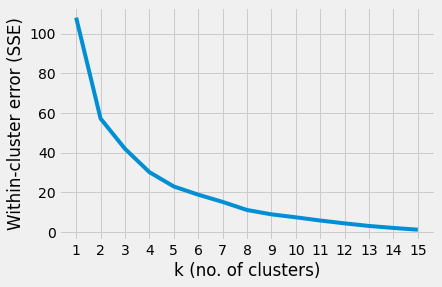

In [21]:
# Choose the best k
km_args = {"init": 'k-means++',     # or, 'random'\
           "n_init": 20,\
           "max_iter": 300,\
           "random_state": 15,}

ks = 15
sse = []
for k in range(1,ks+1):
    KM1 = KMeans(n_clusters=k, **km_args)
    KM1.fit(Xnorm)
    sse.append(KM1.inertia_)

# Elbow Method - Plot SSE Curve
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
plt.plot(range(1, ks+1), sse)
plt.xticks(range(1, ks+1))
plt.xlabel('k (no. of clusters)')
plt.ylabel('Within-cluster error (SSE)')
plt.show()

As in many cases, determining the elbow point in the SSE curve is not always straightforward. Under this situation, we can use the Python package _kneed_ to identify the elbow point programmatically

In [22]:
from kneed import KneeLocator
kl = KneeLocator(range(1, ks+1), sse, curve='convex', direction='decreasing')
kl.elbow

4

It is shown that the elbow point, i.e. best K should be 4!
Now, we could carry on the clustering using this value

In [23]:
k = kl.elbow
KM1 = KMeans(init='k-means++', n_clusters=k, n_init=12)
KM1.fit(Xnorm)

KM1.labels_

array([3, 3, 1, 0, 2, 0, 2, 2, 0, 2, 0, 2, 1, 0, 0, 1, 1, 3], dtype=int32)

In [24]:
# Store result to new DF
Dists3 = Dists2.reset_index()
Dists3['Clus'] = KM1.labels_
Dists3.head()

,Dist,Pop,WorkPop,households,avg_flatsize,Dom_Private,income_median,Lat,Lng,No_Listings,Median,Clus
0,Central & Western,243266,139534,87057,41,94.0,20800,22.2632,114.153,856,513.5,3
1,Wan Chai,180123,106009,65196,47,94.0,20000,22.2665,114.179,1353,300.0,3
2,Eastern,555034,296373,187134,44,64.0,17000,22.2634,114.215,231,300.0,1
3,Southern,274994,143331,85505,41,53.0,16000,22.2573,114.188,39,988.0,0
4,Sham Shui Po,405869,205565,148304,35,60.0,14600,22.3383,114.153,148,250.0,2


### Visualize Results
Having stored the result into a new DF (i.e. district demographics with the cluster labels), we could first visualize the results on a map

In [25]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors

In [26]:
LAT, LNG = 22.38, 114.15
f = folium.Figure(width=600, height=280)
Map_Clus = folium.Map([LAT, LNG], zoom_start=10).add_to(f)

# color scheme
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, k))
c = [colors.rgb2hex(i) for i in colors_array]

for dist, lat, lng, clus in zip(Dists3['Dist'], Dists3['Lat'], Dists3['Lng'], Dists3['Clus']):
    folium.CircleMarker([lat, lng], popup=dist, radius=5, color=c[clus-1], \
                       fill=True, fill_color=c[clus-1], fill_opacity=0.6).add_to(Map_Clus)


Map_Clus

#### Examine Clusters
Also, the detailed data could by displayed cluster by cluster as follows

In [27]:
# Show by Cluster - District Top Venues
pd.set_option('display.max_colwidth',50)
for i in range(k):
    print('\n Cluster', i+1)
    display(Dists3.loc[Dists3['Clus']==i, Dists3.columns[range(0,11)]])


 Cluster 1


,Dist,Pop,WorkPop,households,avg_flatsize,Dom_Private,income_median,Lat,Lng,No_Listings,Median
3,Southern,274994,143331,85505,41,53.0,16000,22.2573,114.188,39,988.0
5,Kowloon City,418732,217224,142409,40,76.0,16500,22.3299,114.189,265,328.0
8,Yau Tsim Mong,342970,183084,126540,40,90.0,15500,22.3147,114.171,2919,355.0
10,Tsuen Wan,318916,168786,109079,44,78.0,17000,22.3924,114.108,28,905.0
13,North,315270,150586,106483,40,46.0,15000,22.5135,114.17,148,352.0
14,Tai Po,303926,153824,99339,41,57.0,16000,22.4496,114.226,20,490.0



 Cluster 2


,Dist,Pop,WorkPop,households,avg_flatsize,Dom_Private,income_median,Lat,Lng,No_Listings,Median
2,Eastern,555034,296373,187134,44,64.0,17000,22.2634,114.215,231,300.0
12,Yuen Long,614178,301676,207336,44,53.0,15000,22.4436,114.071,139,420.0
15,Sha Tin,659794,335202,221821,40,45.0,17000,22.378,114.193,52,354.0
16,Sai Kung,461864,245332,147945,46,49.0,18000,22.3566,114.268,75,500.0



 Cluster 3


,Dist,Pop,WorkPop,households,avg_flatsize,Dom_Private,income_median,Lat,Lng,No_Listings,Median
4,Sham Shui Po,405869,205565,148304,35,60.0,14600,22.3383,114.153,148,250.0
6,Wong Tai Sin,425235,209277,145489,38,18.0,14500,22.3495,114.201,6,555.0
7,Kwun Tong,648541,315577,226487,35,29.0,14100,22.314,114.235,25,560.0
9,Kwai Tsing,520572,259427,174800,35,26.0,14000,22.3607,114.14,25,780.0
11,Tuen Mun,489299,245334,173378,40,45.0,15000,22.4018,114.007,30,400.0



 Cluster 4


,Dist,Pop,WorkPop,households,avg_flatsize,Dom_Private,income_median,Lat,Lng,No_Listings,Median
0,Central & Western,243266,139534,87057,41,94.0,20800,22.2632,114.153,856,513.5
1,Wan Chai,180123,106009,65196,47,94.0,20000,22.2665,114.179,1353,300.0
17,Islands,156801,79815,55035,50,62.0,16000,22.2829,114.021,259,750.0


#### Summary - Features Average across Clusters

Finally, the demographic profile of districts belonging to each cluster could be examined and devised. Since all features are of numerical types, the median data of each features could be summarized and compared across the four clusters:

In [28]:
round(Dists3.groupby('Clus').median(),0)

,Pop,WorkPop,households,avg_flatsize,Dom_Private,income_median,No_Listings,Median
Clus,,,,,,,,
0,317093.0,161305.0,107781.0,40.0,66.0,16000.0,94.0,422.0
1,584606.0,299024.0,197235.0,44.0,51.0,17000.0,107.0,387.0
2,489299.0,245334.0,173378.0,35.0,29.0,14500.0,25.0,555.0
3,180123.0,106009.0,65196.0,47.0,94.0,20000.0,856.0,514.0


Based on the features of each cluster:
* Cluster 0 (Eastern, Yuen Long, Sha Tin, Sai Kung) **Most populated**
  * highest population and working population
  * only around half of the homes are in private developments, but the average flat size is above HK average
  * Income slightly above HK average, and the districts provide a number of AirBNB listings at relatively cheap costs.


* Cluster 1 (Southern, Sham Shui Po, Kowloon City, Yau Tsim Mong, Tsuen Wan, North, Tai Po)  **Average**
  * Captured the highest no. of districts
  * features generally in the middle range
  * has with the cheapest AirBNB listings (HKD 387/day)
  
  
* Cluster 2 (Wong Tai Sin, Kwun Tong, Kwai Tsing, Tuen Mun) **Poorer districts with high population**
  * Relatively high population, but with the lowest average flat size (36 square meters)
  * Lowest income and also extremely low proportion of private accomodations (28%)
  * Suprisingly, has the highest AirBNB room rates (HKD 558/day), but possible due to outliers given the small no. of listings. 


* Cluster 3 (Central & Western, Wan Chai, Islands): **Prime districts in Hong Kong**
  * Lowest population and working popuation, no. of households (supposed to be smaller districts)
  * notably, also lower ratio of population:households (i.e. smaller households)
  * Highest median income, flat size and exceptionally high percentage of private residences
  * has the highest number of AirBNB listings, at a relatively high room rate (HKD 514/day)

### (II) AirBNB Listings <a name="item4.2"></a>

In [29]:
# Revisit the listing DF
print(listings.shape)
listings.head()

(6618, 11)


,id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,69074,160139,Central & Western,22.28352,114.15018,Entire home/apt,1270,3,134,1,177
2,103760,304876,Central & Western,22.28407,114.15570,Entire home/apt,690,2,272,14,364
3,104626,544166,Central & Western,22.28222,114.14834,Entire home/apt,2575,1,14,1,365
5,163664,304876,Central & Western,22.28651,114.14874,Entire home/apt,613,2,223,14,305
6,163742,304876,Central & Western,22.28694,114.14855,Entire home/apt,613,2,231,14,365


since there is a lot of data, we can reduce the bulk by imposing more criteria:
* select listings for the entire home/apartment only
* select listings at price +/-20% of median 

so that the results are more comparable

In [30]:
listings2 = listings[(listings['room_type']=='Entire home/apt')]

median = listings2['price'].median()
print(median)
airbnbs = listings2[(listings2['price']>=median*0.8) & (listings2['price']<=median*1.2)]

airbnbs.drop(['host_id', 'calculated_host_listings_count', 'availability_365'], axis=1, inplace=True)
airbnbs.rename(columns={'id':'ID', 'neighbourhood':'Dist', 'latitude':'Lat', 'longitude':'Lng'}, inplace=True)

print(airbnbs.shape)
airbnbs.head(3)

650.0
(579, 8)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/frame.py:4300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,ID,Dist,Lat,Lng,room_type,price,minimum_nights,number_of_reviews
2,103760,Central & Western,22.28407,114.15570,Entire home/apt,690,2,272
5,163664,Central & Western,22.28651,114.14874,Entire home/apt,613,2,223
6,163742,Central & Western,22.28694,114.14855,Entire home/apt,613,2,231


In [31]:
# see no. of records per district
airbnbs.groupby('Dist').count()['price']

Dist
Central & Western    157
Eastern               16
Islands               35
Kowloon City          33
Kwai Tsing             2
Kwun Tong              3
North                  8
Sai Kung               2
Sha Tin                7
Sham Shui Po           7
Southern               4
Tai Po                 1
Tuen Mun               2
Wan Chai             121
Wong Tai Sin           1
Yau Tsim Mong        158
Yuen Long             22
Name: price, dtype: int64

No. of records should be further limited so as to reduce API run time. In addition, as the number of records flucuates across districts - let's limit number of listings to be used ***in each district***

In [32]:
bnbs = airbnbs.groupby('Dist').head(5)
print(bnbs.shape)

bnbs.groupby('Dist').count()['price']

(65, 8)


Dist
Central & Western    5
Eastern              5
Islands              5
Kowloon City         5
Kwai Tsing           2
Kwun Tong            3
North                5
Sai Kung             2
Sha Tin              5
Sham Shui Po         5
Southern             4
Tai Po               1
Tuen Mun             2
Wan Chai             5
Wong Tai Sin         1
Yau Tsim Mong        5
Yuen Long            5
Name: price, dtype: int64

After limiting no. of data in each district, there is a total 65 Airbnb listings which would be analysised. 
Now, we will <font size=2>***Start utilizing the Foursquare API***</font> to explore the AirBNB listings and segment them

In [33]:
# Foursquare Credentials and Version
Client_ID = input('Foursquare Client ID')Client_Secret = input('Foursquare Client Secret')ver = '20180605' 
Acces_Token = input('Access Token')

#### Explore the vicinity around each Airbn listing
Get 100 venues in the vicinity – for <font color='green'>_each selected AirBNB listings_</font>

In [36]:
# def function: [take in series (label, lat, lng)] Get venues nearby (100 venues, within 1000m)

def getNearbyVenues(IDs, lats, lngs, radius=1000, limit=100):
    venues_list = []

    for ID, lat, lng in zip(IDs, lats, lngs):    # loop thru each hood > GET Req for venues

        # print(name)
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(Client_ID, Client_Secret, ver, lat, lng, radius, limit)
        result = requests.get(url).json()['response']['groups'][0]['items']
        
        # append record (Loc’s info > each venue from GET req in hood) [nested list]
        venues_list.append([(ID, lat, lng, v['venue']['name'], \
                             v['venue']['location']['lat'], v['venue']['location']['lng'], \
                             v['venue']['categories'][0]['name']) for v in result])

        # Nested List > DF
        venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        venues.columns = ['ID', 'ID Lat', 'ID Lng', 'Venue', 'Venue Lat', 'Venue Lng', 'Venue Cat']

    return(venues)

In [37]:
# Call function (getNearbyVenues) on each Dist: Store output to new DF
venues = getNearbyVenues(bnbs['ID'], bnbs['Lat'], bnbs['Lng'])
print(venues.shape)
venues.head()

(3954, 7)


,ID,ID Lat,ID Lng,Venue,Venue Lat,Venue Lng,Venue Cat
0,103760,22.28407,114.1557,Pure Yoga,22.283022,114.155674,Yoga Studio
1,103760,22.28407,114.1557,HK Brewcraft,22.283352,114.154738,Beer Store
2,103760,22.28407,114.1557,001,22.283574,114.154199,Cocktail Bar
3,103760,22.28407,114.1557,The Pottinger (石板街酒店),22.282996,114.155413,Hotel
4,103760,22.28407,114.1557,Four Seasons Hotel Hong Kong (香港四季酒店),22.286554,114.156929,Hotel


In [38]:
venues[venues['ID']==14156961]

,ID,ID Lat,ID Lng,Venue,Venue Lat,Venue Lng,Venue Cat
2523,14156961,22.45293,114.3614,Ko Lau Wan Public Pier (高流灣公眾碼頭),22.458528,114.360528,Pier
2524,14156961,22.45293,114.3614,石記私房菜,22.459132,114.361316,Seafood Restaurant



#### A summary of no. of venues returned and overall no. unique categories of venues

In [39]:
# no. of categories of venues
print('Total. of venues found:', venues.groupby('ID').count().sum()[0])
print('Avg no. of venues around each listing: %d' % (venues.groupby('ID').count().sum()[0]/bnbs.shape[0]))

print('No. of Venue Categories:', len(venues['Venue Cat'].unique()))

Total. of venues found: 3954
Avg no. of venues around each listing: 60
No. of Venue Categories: 255


### Analyze Each District - Type of Venues

In [40]:
# One-hot encoding (on Venue Category)
bnb_onehot = pd.get_dummies(venues['Venue Cat'], prefix='', prefix_sep='')
bnb_onehot['ID'] = venues['ID']

# move district to the first col
cols = [bnb_onehot.columns[-1]] + list(bnb_onehot.columns[:-1])
bnb_onehot = bnb_onehot[cols]

pd.set_option('display.max_columns', 15)
bnb_onehot.head(3)

,ID,ATM,Accessories Store,African Restaurant,Airport Service,American Restaurant,Aquarium,...,Wine Shop,Xinjiang Restaurant,Yoga Studio,Yunnan Restaurant,Zhejiang Restaurant,Zoo,Zoo Exhibit
0,103760,0,0,0,0,0,0,...,0,0,1,0,0,0,0
1,103760,0,0,0,0,0,0,...,0,0,0,0,0,0,0
2,103760,0,0,0,0,0,0,...,0,0,0,0,0,0,0


In [41]:
# Group rows by id > take mean (of cols) > Count of each category
bnb_grp = bnb_onehot.groupby('ID').mean().reset_index()
print(bnb_grp.shape)
bnb_grp.head(3)

(65, 256)


,ID,ATM,Accessories Store,African Restaurant,Airport Service,American Restaurant,Aquarium,...,Wine Shop,Xinjiang Restaurant,Yoga Studio,Yunnan Restaurant,Zhejiang Restaurant,Zoo,Zoo Exhibit
0,103760,0.0,0.01,0.0,0.01,0.0,0.0,...,0.00,0.0,0.03,0.0,0.0,0.0,0.0
1,163664,0.0,0.01,0.0,0.00,0.0,0.0,...,0.01,0.0,0.01,0.0,0.0,0.0,0.0
2,163742,0.0,0.01,0.0,0.00,0.0,0.0,...,0.01,0.0,0.01,0.0,0.0,0.0,0.0



#### Find the top common venues around each listing

In [42]:
# define function: sort venues, return top venues (specified no.)
def return_top_venues(row, no_top):
    row_cat = row.iloc[1:]
    row_cat_sorted = row_cat.sort_values(ascending=False)
    return row_cat_sorted.index.values[:no_top]

In [43]:
# Create DF for results (column headers > get top venues for each listing (i.e. row))
no_top = 5
cols = ['ID'] + ['Rank'+str(i+1) for i in range(no_top)]
bnb_top = pd.DataFrame(columns=cols)
bnb_top

,ID,Rank1,Rank2,Rank3,Rank4,Rank5


In [44]:
# Add ID into DF (to return values)
bnb_top['ID'] = bnb_grp['ID']

for i in range(bnb_grp.shape[0]):
    bnb_top.iloc[i, 1:] = return_top_venues(bnb_grp.iloc[i,:], no_top)

bnb_top

,ID,Rank1,Rank2,Rank3,Rank4,Rank5
0,103760,Japanese Restaurant,Coffee Shop,Bar,Bakery,Hotel
1,163664,Coffee Shop,Japanese Restaurant,Café,Hotel,Wine Bar
2,163742,Coffee Shop,Japanese Restaurant,Café,Chinese Restaurant,Wine Bar
3,498484,Dim Sum Restaurant,Dessert Shop,Cha Chaan Teng,Noodle House,Coffee Shop
4,505160,Café,Beach,Bar,Coffee Shop,Restaurant
5,548840,Coffee Shop,Café,Hong Kong Restaurant,Chinese Restaurant,Hotel
6,767160,Coffee Shop,Cha Chaan Teng,Japanese Restaurant,Sushi Restaurant,Chinese Restaurant
7,825791,Hotel,Japanese Restaurant,Café,Hotel Bar,Italian Restaurant
8,846482,Hong Kong Restaurant,Coffee Shop,Chinese Restaurant,Hotel,Italian Restaurant
9,1022377,Café,Restaurant,Campground,Chinese Restaurant,Theme Restaurant


#### Cluster Districts (by top venues)

<font size=2> ***Find best k by Elbow method*** </font>\
again, we can identify the best number of clusters using Elbow method

In [45]:
bnb_clus = bnb_grp.drop('ID',1) # Top venues as features for clustering
ks=15

inertia=[]
for k in range(1,ks+1):
    KM1 = KMeans(n_clusters=k, random_state=10, n_init=20).fit(bnb_clus)
    inertia.append(KM1.inertia_)

In [46]:
kl = KneeLocator(range(1, ks+1), inertia, curve='convex', direction='decreasing')
kl.elbow

4

<font size=2> ***adopt the best k for clustering*** </font>

In [47]:
k = kl.elbow
KM1 = KMeans(init='k-means++', n_clusters=k, random_state=10, n_init=20).fit(bnb_clus)

In [48]:
# Create DF: District Info - incl cluster labels
try: 
    bnb_top.drop('Clus', 1, inplace=True)
    bnb_top.insert(0, 'Clus', KM1.labels_)
except: bnb_top.insert(0, 'Clus', KM1.labels_)

bnbs2 = bnb_top.merge(bnbs.set_index('ID'), on='ID')
bnbs2.head()

,Clus,ID,Rank1,Rank2,Rank3,Rank4,Rank5,Dist,Lat,Lng,room_type,price,minimum_nights,number_of_reviews
0,1,103760,Japanese Restaurant,Coffee Shop,Bar,Bakery,Hotel,Central & Western,22.28407,114.15570,Entire home/apt,690,2,272
1,1,163664,Coffee Shop,Japanese Restaurant,Café,Hotel,Wine Bar,Central & Western,22.28651,114.14874,Entire home/apt,613,2,223
2,1,163742,Coffee Shop,Japanese Restaurant,Café,Chinese Restaurant,Wine Bar,Central & Western,22.28694,114.14855,Entire home/apt,613,2,231
3,1,498484,Dim Sum Restaurant,Dessert Shop,Cha Chaan Teng,Noodle House,Coffee Shop,Yau Tsim Mong,22.32193,114.16213,Entire home/apt,535,4,60
4,1,505160,Café,Beach,Bar,Coffee Shop,Restaurant,Southern,22.21972,114.20900,Entire home/apt,720,3,29


#### Visualize the Clusters formed

In [49]:
f = folium.Figure(width=800, height=300)
Map_Clusters = folium.Map(location=[LAT, LNG], zoom_start=10).add_to(f)

# Set color scheme (for each cluster)
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0,1,len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Show each AIRBNB listing
for ID, lat, lng, clus in zip(bnbs2['ID'], bnbs2['Lat'], bnbs2['Lng'], bnbs2['Clus']):
    folium.CircleMarker([lat, lng], radius=5, popup=str(ID),\
                        color=rainbow[clus-1], \
                       fill=True, fill_color=rainbow[clus-1], fill_opacity=0.5).add_to(Map_Clusters)

Map_Clusters

#### Examine Clusters
As shown from the above map which visualize the result of clustering for various listings, little differences could be noted from the categories of venues in the surrounds of the flats.

The vast majority of the listings belong to one of the clusters, whereas the remaining scatter across different clusters.

We could then look into details of the **most common venues** found around the Airbnb listings in the clusters formed.

In [ ]:
# Show by Cluster - District Top Venues
pd.set_option('display.max_colwidth',50)
for i in range(k):
    print('\n Cluster', i)
    display(bnbs2.loc[bnbs2['Clus']==i, bnbs2.columns[range(1,8)]])

First, looking at ***Cluster 1*** which houses the vast majority of the listings, it is obvious that restaurants providing a variety of cuisines are the most commonly found venues. In most of the cases shown, restaurants, cafes/coffe shops, bar and bakery accounts for four out of five of the top venues.

***Cluster 0***, the next "largest cluster" comprises only 3 listings. Notably, all these listings are located near the border, and thus facilities including Border Crossing, Pier, and Train Stations were found in the vicinity. 

***Cluster 2 and 3*** each contain only one listing, i.e. each represent a nature of neighbourhood. Some unique types of facilities were common found around these locations, including Zoo Exhibit, Fish Market, and General Entertainment. Also, in comparison to the more commonly found restaurants in Cluster 1, BBQ Joints, Seafood Restaurants and Gastropubs were included for these 2 listings.

## Results and Discussion <a name="item5"></a>

In the first part of the analysis, different districts of Hong Kong have been analysed by reference to the demographic data and four clusters of different features have been identified. 
* In particular, **Cluster 3** (Central & Western, Wan Chai, Islands) comprises the districts with the highest average income and the lowest population in Hong Kong. Notably, these districts has the smallest average size of households but the largest flat sizes. On top of that, these 3 districts accounts for the majority of the Airbnb listings found.
* Meanwhile, **Cluster 2** (Wong Tai Sin, Kwun Tong, Kwai Tsing, Tuen Mun) has the lowest average income and flat sizes while having a relatively high population. While having the lowest number of Airbnb listings, they however has the highest average rental among all clusters.
* The largest domestic population and working population were found in Cluster 0 (Eastern, Yuen Long, Shatin and Sai Kung). Other than that, features of **Cluster 0 and 1** (Southern, Sham Shui Po, Kowloon City, Yau Tsim Mong, Tsuen Wan, North and Tai Po) display values within the middle range.


After directing our attention to a selected number of Airbnb listings from each of the districts (removing outliers and selected records of similar daily rental and properties, we have obtained a total of 65 listings and explored around each of these locations using Foursquare API. Setting a radius of 1,000m and a limit of 100 venues, we have searched for venues around each listings and subsequently identified the most common category of venues corresponding.

Those location candidates were then clustered to create **4 zones**, each displaying different composition of neighbourhoods. 
* Remarkably, the vast majority of the listings were categorized into the same group **(Cluster 1)**, all surrounded mainly by restaurants of different styles. 
* Some of the flats were located near the border near some of the major border or transportation facilities **(Cluster 0)**.
* On the other hand, **(Cluster 2 and 3)** display unique neighborhoods, where more special venues (e.g. Zoo Exhibit, Garden) and specialty restaurants (e.g. Seafood restaurants, Gastropub) could be found. It is however noted that each of these cluster contain only one listing

The result of the second clustering shows that for Airbnb listings with middle-range rentals in different districts of Hong Kong, the majority of their neighborhoods (categorized by the type of venues in the surroundings) are generally similar. Only a few special cases were noted, which are all located in very remote locations in the New Territories of Hong Kong.

It should be cautioned that this does not provide a definitive conclusion for the property market in Hong Kong. While Airbnb rentals could be of reference value for the subject topic, this sector represent a combination of traditional residential and hotel market, which may display different properties. However, the data source is still considered preferable in adopting given its ease of acquisition, abundance of volumn and availibity of different features.

In addition, different results may be arrived at with a different featureset (e.g. demographic attributes in Part I) or different amount of data used (e.g. more or different listings in Part II). Also, various parameters adopted in the analysis may also carry weight in the result. For instance, using different radius and limit in the FourSquare API calls, or change the number of top venues for consideration)

Further investigation is therefore recommended so as to better understand (1) demographics of different district in Hong Kong, and (2) the nature of neighbourhood around properties in different areas.

## Conclusion <a name="item6"></a>

The purpose of this project was mainly exploratory. The first part aimed at understanding the demographic properties of the 18 districts in Hong Kong and segment them into clusters, whereas the second part attempted to look into the neighbourhoods around similar properties across districts.

By extracting key demographic features from the dataset, noramlising and applying k-Means clustering, we have arrived at four clusters displaying distinct profiles of features. 

Next, we have explored the airbnb listing data and filtered the dataset (removing outliers and setting certain criterias) to select 65 representative listings having similar price range and properties while located at different districts. By utilising Foursquare data, we have retrieved the venues available in the vicinity of these listings. Further analysis have been conducted on the category of these venues, and the 5 most common type of venues in each listing have been produced. 

Finally, the representative listings have been clustered based on the most common type of venues and the result revealed that the neighbourhood profile of most of the listings are largely similar (i.e. mainly surroundinged by restaurants of different types). Very few listings were categoried into the remaining 3 clusters, all of which are located at remote locations.

Since assumptions such as target daily room rates were not made for the project, discussion with the stakeholders will be on this matter. Changing the listings used with those of a different price range could yield different results. As a final note, a major limitation of the _inside airbnb_ dataset is that property size were not available - which is  potentitially a key determinator for the listings.